In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('classic')

# 단순한 계층 구현하기

## 곱셈 계층

In [14]:
class MulLayer :
    def __init__(self) :
        self.x = None
        self.y = None
        
    def forward(self, x, y) :
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout) :
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [15]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [16]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


## 덧셈 계층

In [17]:
class AddLayer :
    def __init__(self) :
        pass
    
    def forward(self, x, y) :
        out = x + y
        return out
    
    def backward(self, dout) :
        dx = dout * 1
        dy = dout * 1
        return dx, dy 

### 사과 2개, 귤 3개를 사서 소비세를 더한 값을 구하는 계층

In [18]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


# ReLU 계층

In [19]:
class Relu :
    def __init__(self) :
        self.mask = None
        
    def forward(self, x) :
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        dx = dout
        
        return dx

# Sigmoid 계층

In [20]:
class Sigmoid :
    def __init__(self) :
        self.out = None
        
    def forward(self, x) :
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout) :
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

# Affine 계층

In [21]:
class Affine :
    def __init__(self, W, b) :
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x) :
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout) :
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [22]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *

class SoftmaxWithLoss :
    def __init__(self) :
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t) :
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1) :
        # 역전파시에는 batch 수로 나눠야 데이터 1개당 오차를 앞 계층으로 전파한다.
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

# 오차역전파법을 적용한 신경망 구현하기

In [23]:
from collections import OrderedDict
from common.gradient import numerical_gradient

class TwoLayerNet :
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01) :
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x) :
        for layer in self.layers.values() :
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t) :
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t) :
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t) :
        loss_W = lambda W : self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t) :
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())[::-1]
        
        for layer in layers :
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads
            
        

In [24]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

X_batch = X_train[:3]
y_batch = y_train[:3]

grad_numerical = network.numerical_gradient(X_batch, y_batch)
grad_backprop = network.gradient(X_batch, y_batch)

for key in grad_numerical.keys() :
    diff = np.average(np.abs(grad_numerical[key] - grad_backprop[key]))
    print(key, ":", diff)

W1 : 4.5112262341962977e-10
b1 : 3.076852934765428e-09
W2 : 6.6489625460587765e-09
b2 : 1.3998804312131962e-07


In [27]:
(X_train, y_train), (X_test, y_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10_000
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num) :
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.gradient(X_batch, y_batch)
    
    for key in ['W1','b1','W2','b2'] :
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(X_batch, y_batch)
    train_loss_list.append(loss)
    
    if i % 100 == 0 :
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


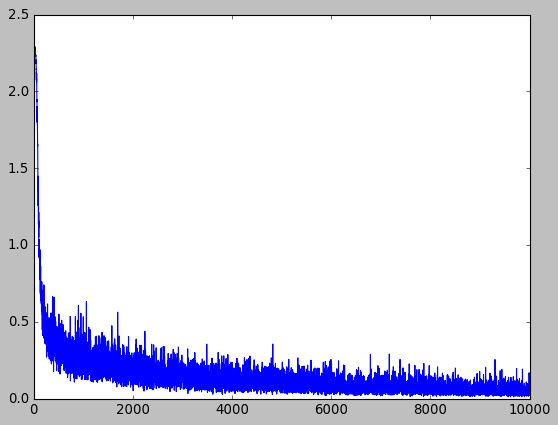

In [28]:
# 손실함수
plt.plot(train_loss_list)

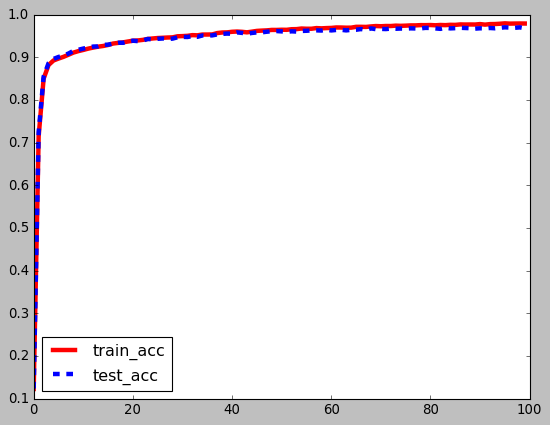

In [29]:
# 훈련 데이터와 테스트 데이터의 정확도
plt.plot(train_acc_list, label='train_acc', lw='4', c='r')
plt.plot(test_acc_list, label='test_acc', lw='4', c='b', ls='--')
plt.legend(loc='best')
plt.show()